## Lesson 4 HomeWork

In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

%matplotlib inline

### Задание 1.

Скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention.

In [27]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [28]:

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


### Задание 2.

Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [29]:
df['conversion'].value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

In [30]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [31]:
# Переименовываем
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [32]:
# Приводим в бинарный вид
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df['treatment'] = df['treatment'].astype(np.uint8)

In [33]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


### Задание 3.

Сделать разбиение набора данных не тренировочную и тестовую выборки.

In [34]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df.drop(columns=['target']), 
                                                            df['target'],
                                                            df['treatment'],
                                                            random_state=42)

### Задание 4. 
Сделать feature engineering на ваше усмотрение (допускается свобода выбора методов).

### Задание 5.
Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями.

In [35]:
# Датафрейм для сравнения метрик
metrics = pd.DataFrame(columns=['uplift@10%', 'uplift@20%'])

In [36]:
# Категориальные признаки:
cat_features = ['zip_code', 'channel']

**Solo learner**

[0.03823428 0.09231884 0.07467323 ... 0.05090824 0.06461601 0.05011143]


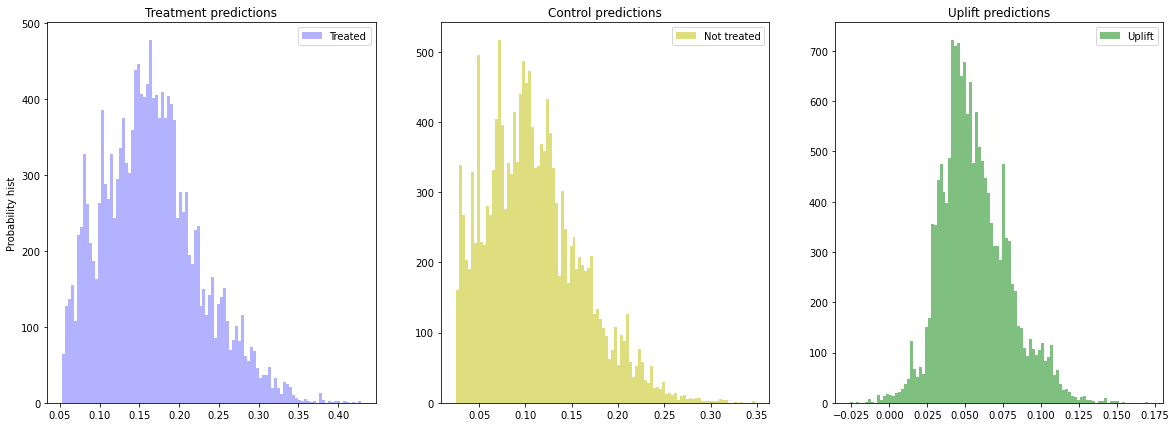

In [37]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)
print(uplift_sm)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

# Сохраняем метрики
metrics = metrics.append({'uplift@10%': sm_score_10, 'uplift@20%': sm_score_20}, ignore_index=True)

**Transform Learner**

In [38]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)
print(uplift_ct)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

# Сохраняем метрики
metrics = metrics.append({'uplift@10%': ct_score_10, 'uplift@20%': ct_score_20}, ignore_index=True)

[-0.83653901 -0.52705406 -0.60651056 ... -0.59874417 -0.79529475
 -0.71510109]


**Two Model Learner**

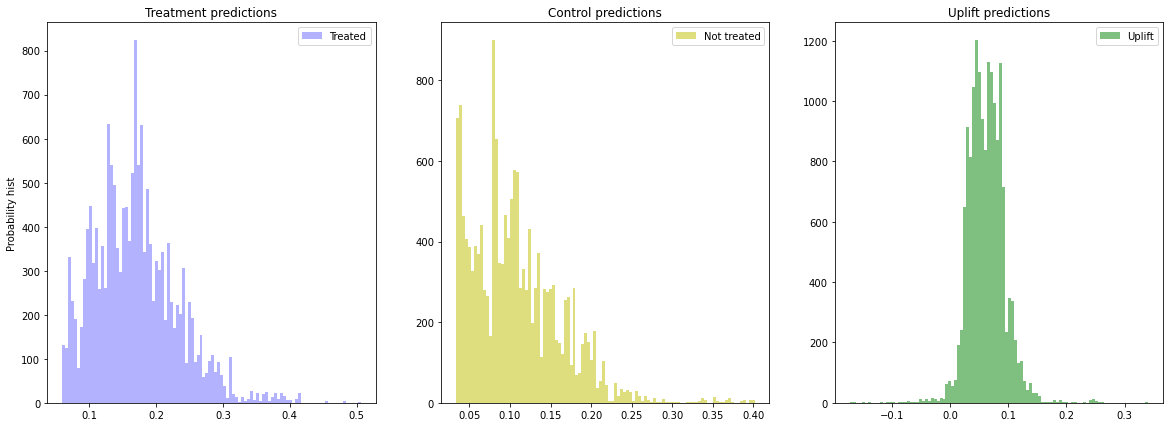

In [39]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
tm_trmnt_preds = tm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
tm_ctrl_preds = tm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=tm_trmnt_preds, ctrl_preds=tm_ctrl_preds);

# Сохраняем метрики
metrics = metrics.append({'uplift@10%': tm_score_10, 'uplift@20%': tm_score_20}, ignore_index=True)

### Задание 6.

В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей.

In [40]:
metrics

,uplift@10%,uplift@20%
0,0.135178,0.112432
1,0.290529,0.231714
2,0.115410,0.095982


Метод ClassTransformation показал лучшие результаты.